### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


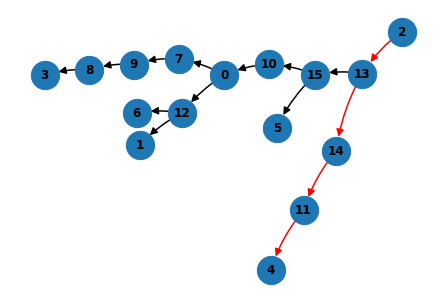

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

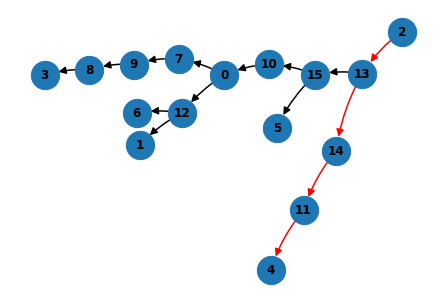

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 1>8,4>2,5>7,15>5,11>4,13>1,10>11,13>15,13>9,12>14,0>6,9>3,8>12,3>10,1>0|7:13
Completion: >15>5>7

Prompt: 11>15,8>11,3>1,5>6,10>12,2>7,10>5,12>13,2>3,3>4,13>0,10>9,2>8,3>14,14>10|9:2
Completion: >3>14>10>9

Prompt: 12>5,4>6,13>9,7>8,9>15,1>14,8>11,1>13,0>10,15>2,12>1,5>0,0>7,2>4,1>3|14:12
Completion: >1>14

Prompt: 10>11,3>4,8>6,13>14,9>10,3>12,11>13,2>9,5>2,13>8,13>1,13>7,3>15,1>0,11>3|4:5
Completion: >2>9>10>11>3>4

Prompt: 15>5,13>6,12>1,10>3,7>11,11>15,6>4,12>7,2>9,0>8,14>0,5>2,2>10,15>13,10>14|9:12
Completion: >7>11>15>5>2>9

Prompt: 13>6,11>3,1>12,9>14,4>2,6>4,6>9,7>13,6>5,4>15,10>0,6>10,4>11,3>8,6>1|0:7
Completion: >13>6>10>0

Prompt: 14>8,8>13,8>2,10>3,0>12,0>1,6>15,14>0,1>4,7>6,9>10,2>11,3>5,14>7,0>9|13:14
Completion: >8>13

Prompt: 14>15,8>4,7>6,9>8,6>10,11>12,15>13,1>0,15>2,7>11,6>14,12>1,1>5,6>3,8>7|3:9
Completion: >8>7>6>3

Prompt: 4>13,11>14,8>3,15>9,2>4,1>5,7>10,4>0,5>7,5>6,8>15,0>8,8>1,9>12,3>11|6:2
Completion: >4>0>8>1>5>6

Prompt: 6>12,9>11,15>2,4>0,14>10,10>4

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [7]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


6>3,5>4,11>13,14>6,14>5,12>7,12>11,12>14,1>12,1>8,15>1,2>15,10>9,0>2,0>10|13:0>2>15>1>12>11>13


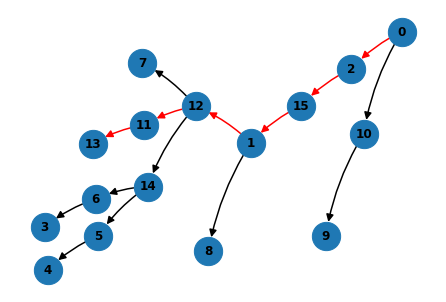

In [8]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [9]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=False)

### Experiment: Logit Lens

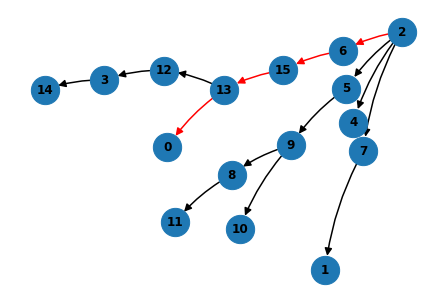

In [10]:
test_graph = generate_example(n_states, 400_000, order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)

In [11]:
logit_lens(pred, model, dataset)

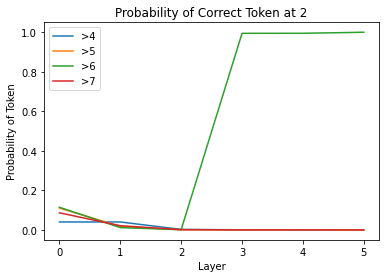

In [12]:
logit_lens_all_probs(pred, model, dataset, 47)

In [16]:
lenses = calculate_tuned_lens(model, dataset)

0.5742078288829846
0.592591483503099
0.6271814799550283
0.7376448848674818
0.8749300656904998
0.9772625404812034


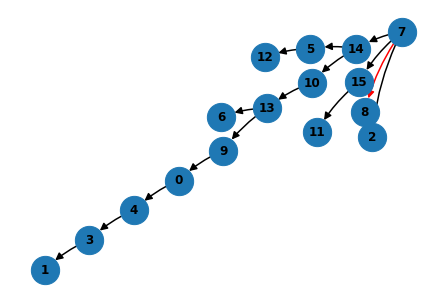

In [14]:
test_graph = generate_example(n_states, 900_000, order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)

In [15]:
logit_lens(pred, model, dataset, lenses=lenses)

### Experiment: Attention Blockout ACDC

In [ ]:
model.reset_hooks()
parse_example(test_graph)

In [ ]:
ablated_edges, important_edges = attention_knockout_discovery(model, dataset, test_graph)

In [ ]:
model.reset_hooks()

for L in ablated_edges.keys():
    inds = ablated_edges[L]
    if len(inds) == 0:
        continue
    add_attention_blockout_parallel(model, L, inds)

pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)

In [ ]:

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)


In [ ]:
G = nx.DiGraph()

for pos, label in enumerate(labels):
    for layer in range(model.cfg.n_layers+1):
        G.add_node(f"{label}_{pos}_{layer}", layer=layer)

for L in important_edges.keys():
    for h, curr, attend in important_edges[L]:
        G.add_edge(f"{labels[attend]}_{attend}_{L}", f"{labels[curr]}_{curr}_{L+1}")


# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")

fig, ax = plt.subplots(figsize=(20, 25))
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

### Experiment: Looking at Embeddings

In [ ]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume that 'data' is your original dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_nodes)

pca = PCA(n_components=2)  # k is the desired number of components
data_transformed = pca.fit_transform(data_scaled)

fig, ax = plt.subplots()

plt.scatter(data_transformed[:16, 0], data_transformed[:16, 1], color="blue")
plt.scatter(data_transformed[16:, 0], data_transformed[16:, 1], color="orange")

### Experiment: Probing


In [ ]:
X, graphs = aggregate_activations(
    model=model,
    dataset=dataset,
    activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
    n_states=n_states,
    n_samples=1_024
)

for key in X.keys():
   tensor_list = [ x[0, [i for i in range(45) if (i-1) % 3 == 0], 0] for x in X[key] ]
   X[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()

In [ ]:
from sklearn import preprocessing
y = {"incoming": [], "outgoing": []}

for graph in graphs:
    tokens = dataset.tokenize(graph)[:-1]
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
    y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])

y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )

In [ ]:
for xkey in X.keys():    
    for ykey in y.keys():
        score = linear_probing(X[xkey], y[ykey])
        print(f"Layer {xkey.split('.')[1]} {ykey} node probe - {score:.3f}")

In [ ]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["outgoing"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Outgoing Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["incoming"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Incoming Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

### Experiment: Low Rank Approximation of Attention

In [ ]:
from functools import partial


def add_low_rank_hook(layer, k):
    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X[utils.get_act_name("v", layer, "attn")])

    # Add low-rank hook
    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre

    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [ ]:
model.reset_hooks()
n_pca = 20

add_low_rank_hook(3, n_pca)
add_low_rank_hook(4, n_pca)
add_low_rank_hook(5, n_pca)

In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

### Experiment: Activation Patching

In [ ]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt


def goal_distance_activation_patching(distance):
    # Generate clean and corrupted prompts
    clean_prompt, corrupted_prompt = generate_goal_distance_examples(distance)
    parse_example(clean_prompt)
    plt.show()
    parse_example(corrupted_prompt)
    plt.show()
    # Tokenize
    clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
    corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
    patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + (15 - distance + 1) )
    return patching_result, clean_tokens

In [ ]:
model.reset_hooks()
patchings = [goal_distance_activation_patching(i) for i in range(1, 15)]

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

model.reset_hooks()
# Create a figure
fig = plt.figure()

# Function to update each frame
def update(i):
    plt.clf()
    plt.imshow(patchings[i][0].detach().cpu().numpy(), cmap='RdBu')

# Create animation

ani = animation.FuncAnimation(fig, update, frames=len(patchings), interval=200)
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1800)

# Save as mp4
ani.save('myAnimation.mp4', writer=writer)
HTML(ani.to_jshtml())


In [ ]:
index = 6
%matplotlib inline
plot_activations(patchings[index][0], patchings[index][1], dataset)


In [ ]:
patchings[index][0]